In [ ]:
import os
import zipfile

# ZIP dosyanızın yolu
zip_path = '/content/drive/MyDrive/archive.zip'

# Aynı dizini hedef dizin olarak belirle
extract_dir = os.path.dirname(zip_path)

# Çıkarma işlemi
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"ZIP dosyası başarıyla açıldı: {extract_dir}")


ZIP dosyası başarıyla açıldı: /content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
import random
import shutil
import os
import cv2
import tensorflow as tf

# TensorFlow Keras modüllerini kullanıyoruz.
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import preprocess_input

from matplotlib import pyplot as plt


In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
 # number of pixels. change this to 512 if you want to use the full image size. note: will slow computations

dataPath = '/content/drive/MyDrive/eyepac-light-v2-512-jpg'

def addNoise(image):
    # Görüntüyü uint8’e çevir, boyut al
    img = image.astype(np.uint8)
    h, w, _ = img.shape

    # Siyah (karanlık) bölgeleri maske ile bul
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    # Rastgele sigma ile aynı boyutta Gaussian gürültü oluştur
    sigma = random.uniform(0, 10.0)
    gaussian = np.random.normal(loc=0.0, scale=sigma, size=(h, w, 3))

    # Gürültüyü ekle, dışarı taşanları kırp
    noisy = img.astype(np.float32) + gaussian
    noisy = np.clip(noisy, 0, 255)

    # Karartılmış pikselleri sıfırla
    noisy[mask == 0] = 0.0

    return noisy.astype(np.float32)
# combine two unique generators using noise injection and moderate preprocessing
batchSize = 8
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True, channel_shift_range=10, width_shift_range=0.05, height_shift_range=0.05,rotation_range=360,shear_range=30, brightness_range=(0.95, 1.05),  fill_mode = 'constant', cval=0, zoom_range=0.05)
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + '/train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + '/train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=None)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + '/validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=None)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + '/test', color_mode='rgb')

Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [ ]:
# 1) Gerekli kütüphaneleri içe aktarın
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications.convnext import ConvNeXtTiny

# 2) Modeli tanımlayan fonksiyon
def get_model(image_size, num_classes):
    inputs = keras.Input(shape=(image_size, image_size, 3), name='input_image')

    # ConvNeXtTiny: ön işlemeyi kendi içinde yapıyor
    backbone = ConvNeXtTiny(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs,
    )

    x = layers.GlobalMaxPool2D()(backbone.output)
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=1e-1)
    )(x)

    # Binary ise sigmoid, multi-class ise softmax
    act = 'sigmoid' if num_classes == 1 else 'softmax'
    outputs = layers.Dense(num_classes, activation=act)(x)

    return keras.Model(inputs, outputs)

# 3) 'target' ve sınıf sayısını tanımlayın
target = 224      # örn. 224×224 piksel giriş
num_classes = 1   # binary sınıflandırma için 1

# 4) Modeli oluşturun ve özetini yazdırın
model = get_model(image_size=target, num_classes=num_classes)
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 56, 56,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ add_18[0][0]      │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st

 Total params: 27,869,409 (106.31 MB)

 Trainable params: 27,869,409 (106.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=1, min_lr=1e-5)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='binary_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen1, steps_per_epoch = len(trainGen1),validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.8166 - binary_accuracy: 0.7387 - loss: 121.9513 - precision: 0.7401 - recall: 0.7602

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 240s 172ms/step - auc: 0.8167 - binary_accuracy: 0.7388 - loss: 121.8923 - precision: 0.7402 - recall: 0.7602 - val_auc: 0.9547 - val_binary_accuracy: 0.8883 - val_loss: 0.9291 - val_precision: 0.9188 - val_recall: 0.8519 - learning_rate: 1.0000e-04
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9386 - binary_accuracy: 0.8716 - loss: 0.6967 - precision: 0.8696 - recall: 0.8774

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - auc: 0.9386 - binary_accuracy: 0.8716 - loss: 0.6966 - precision: 0.8696 - recall: 0.8774 - val_auc: 0.9653 - val_binary_accuracy: 0.9013 - val_loss: 0.4511 - val_precision: 0.9304 - val_recall: 0.8675 - learning_rate: 1.0000e-04
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.9426 - binary_accuracy: 0.8841 - loss: 0.4656 - precision: 0.8740 - recall: 0.8978

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 169s 169ms/step - auc: 0.9426 - binary_accuracy: 0.8841 - loss: 0.4656 - precision: 0.8740 - recall: 0.8978 - val_auc: 0.9746 - val_binary_accuracy: 0.9286 - val_loss: 0.3688 - val_precision: 0.9125 - val_recall: 0.9481 - learning_rate: 1.0000e-04
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9578 - binary_accuracy: 0.8985 - loss: 0.4007 - precision: 0.8897 - recall: 0.9103

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 171s 171ms/step - auc: 0.9578 - binary_accuracy: 0.8985 - loss: 0.4007 - precision: 0.8897 - recall: 0.9103 - val_auc: 0.9780 - val_binary_accuracy: 0.9195 - val_loss: 0.3495 - val_precision: 0.9401 - val_recall: 0.8961 - learning_rate: 1.0000e-04
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.9603 - binary_accuracy: 0.9031 - loss: 0.3864 - precision: 0.8982 - recall: 0.9100

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 172s 172ms/step - auc: 0.9603 - binary_accuracy: 0.9031 - loss: 0.3864 - precision: 0.8982 - recall: 0.9100 - val_auc: 0.9814 - val_binary_accuracy: 0.9325 - val_loss: 0.3126 - val_precision: 0.9280 - val_recall: 0.9377 - learning_rate: 1.0000e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.9677 - binary_accuracy: 0.9123 - loss: 0.3563 - precision: 0.9071 - recall: 0.9136

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - auc: 0.9676 - binary_accuracy: 0.9123 - loss: 0.3563 - precision: 0.9071 - recall: 0.9136 - val_auc: 0.9749 - val_binary_accuracy: 0.9312 - val_loss: 0.3343 - val_precision: 0.9192 - val_recall: 0.9455 - learning_rate: 1.0000e-04
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9663 - binary_accuracy: 0.9125 - loss: 0.3507 - precision: 0.9048 - recall: 0.9226

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - auc: 0.9663 - binary_accuracy: 0.9125 - loss: 0.3507 - precision: 0.9048 - recall: 0.9226 - val_auc: 0.9789 - val_binary_accuracy: 0.9299 - val_loss: 0.3249 - val_precision: 0.9461 - val_recall: 0.9117 - learning_rate: 9.5000e-05
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9728 - binary_accuracy: 0.9272 - loss: 0.3199 - precision: 0.9135 - recall: 0.9431

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - auc: 0.9728 - binary_accuracy: 0.9272 - loss: 0.3199 - precision: 0.9135 - recall: 0.9431 - val_auc: 0.9796 - val_binary_accuracy: 0.9247 - val_loss: 0.3007 - val_precision: 0.9383 - val_recall: 0.9091 - learning_rate: 9.0250e-05
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9742 - binary_accuracy: 0.9269 - loss: 0.3121 - precision: 0.9225 - recall: 0.9351

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - auc: 0.9742 - binary_accuracy: 0.9269 - loss: 0.3121 - precision: 0.9225 - recall: 0.9351 - val_auc: 0.9793 - val_binary_accuracy: 0.9286 - val_loss: 0.2939 - val_precision: 0.9167 - val_recall: 0.9429 - learning_rate: 9.0250e-05
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 169s 169ms/step - auc: 0.9764 - binary_accuracy: 0.9298 - loss: 0.2999 - precision: 0.9278 - recall: 0.9353 - val_auc: 0.9830 - val_binary_accuracy: 0.9208 - val_loss: 0.3162 - val_precision: 0.9551 - val_recall: 0.8831 - learning_rate: 9.0250e-05
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9784 - binary_accuracy: 0.9306 - loss: 0.2931 - precision: 0.9278 - recall: 0.9311

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 168s 168ms/step - auc: 0.9784 - binary_accuracy: 0.9306 - loss: 0.2931 - precision: 0.9278 - recall: 0.9311 - val_auc: 0.9752 - val_binary_accuracy: 0.9390 - val_loss: 0.2818 - val_precision: 0.9289 - val_recall: 0.9506 - learning_rate: 8.5737e-05
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9765 - binary_accuracy: 0.9306 - loss: 0.2878 - precision: 0.9214 - recall: 0.9411

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - auc: 0.9765 - binary_accuracy: 0.9306 - loss: 0.2877 - precision: 0.9214 - recall: 0.9411 - val_auc: 0.9788 - val_binary_accuracy: 0.9247 - val_loss: 0.3065 - val_precision: 0.9504 - val_recall: 0.8961 - learning_rate: 8.5737e-05
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.9812 - binary_accuracy: 0.9381 - loss: 0.2695 - precision: 0.9356 - recall: 0.9406

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 171s 170ms/step - auc: 0.9812 - binary_accuracy: 0.9381 - loss: 0.2695 - precision: 0.9356 - recall: 0.9406 - val_auc: 0.9783 - val_binary_accuracy: 0.9390 - val_loss: 0.2856 - val_precision: 0.9311 - val_recall: 0.9481 - learning_rate: 8.1451e-05
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 169s 169ms/step - auc: 0.9808 - binary_accuracy: 0.9399 - loss: 0.2618 - precision: 0.9344 - recall: 0.9480 - val_auc: 0.9800 - val_binary_accuracy: 0.9455 - val_loss: 0.2601 - val_precision: 0.9256 - val_recall: 0.9688 - learning_rate: 7.7378e-05
Epoch 15/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9810 - binary_accuracy: 0.9431 - loss: 0.2507 - precision: 0.9357 - recall: 0.9509

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 168s 168ms/step - auc: 0.9810 - binary_accuracy: 0.9431 - loss: 0.2507 - precision: 0.9357 - recall: 0.9509 - val_auc: 0.9845 - val_binary_accuracy: 0.9338 - val_loss: 0.2580 - val_precision: 0.9441 - val_recall: 0.9221 - learning_rate: 7.7378e-05
Epoch 16/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9835 - binary_accuracy: 0.9454 - loss: 0.2447 - precision: 0.9409 - recall: 0.9514

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 171s 171ms/step - auc: 0.9835 - binary_accuracy: 0.9454 - loss: 0.2447 - precision: 0.9409 - recall: 0.9514 - val_auc: 0.9807 - val_binary_accuracy: 0.9325 - val_loss: 0.2824 - val_precision: 0.9464 - val_recall: 0.9169 - learning_rate: 7.7378e-05
Epoch 17/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9846 - binary_accuracy: 0.9498 - loss: 0.2359 - precision: 0.9426 - recall: 0.9575

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 171s 171ms/step - auc: 0.9846 - binary_accuracy: 0.9498 - loss: 0.2359 - precision: 0.9426 - recall: 0.9575 - val_auc: 0.9795 - val_binary_accuracy: 0.9455 - val_loss: 0.2436 - val_precision: 0.9277 - val_recall: 0.9662 - learning_rate: 7.3509e-05
Epoch 18/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9887 - binary_accuracy: 0.9513 - loss: 0.2254 - precision: 0.9446 - recall: 0.9591

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 168s 168ms/step - auc: 0.9887 - binary_accuracy: 0.9513 - loss: 0.2254 - precision: 0.9446 - recall: 0.9591 - val_auc: 0.9816 - val_binary_accuracy: 0.9455 - val_loss: 0.2502 - val_precision: 0.9432 - val_recall: 0.9481 - learning_rate: 7.3509e-05
Epoch 19/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 169ms/step - auc: 0.9873 - binary_accuracy: 0.9548 - loss: 0.2181 - precision: 0.9495 - recall: 0.9600 - val_auc: 0.9827 - val_binary_accuracy: 0.9442 - val_loss: 0.2531 - val_precision: 0.9275 - val_recall: 0.9636 - learning_rate: 6.9834e-05
Epoch 20/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.9894 - binary_accuracy: 0.9587 - loss: 0.2027 - precision: 0.9493 - recall: 0.9695

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 169s 169ms/step - auc: 0.9894 - binary_accuracy: 0.9587 - loss: 0.2027 - precision: 0.9493 - recall: 0.9695 - val_auc: 0.9786 - val_binary_accuracy: 0.9403 - val_loss: 0.2556 - val_precision: 0.9544 - val_recall: 0.9247 - learning_rate: 6.6342e-05


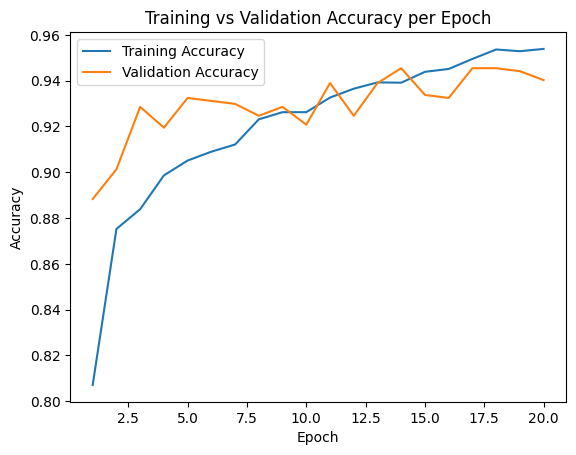

In [ ]:
import matplotlib.pyplot as plt

# history, model.fit(...)'ten dönen History objesi
train_acc = history.history['binary_accuracy']
val_acc   = history.history['val_binary_accuracy']
epochs    = range(1, len(train_acc) + 1)

plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy per Epoch')
plt.legend()
plt.show()


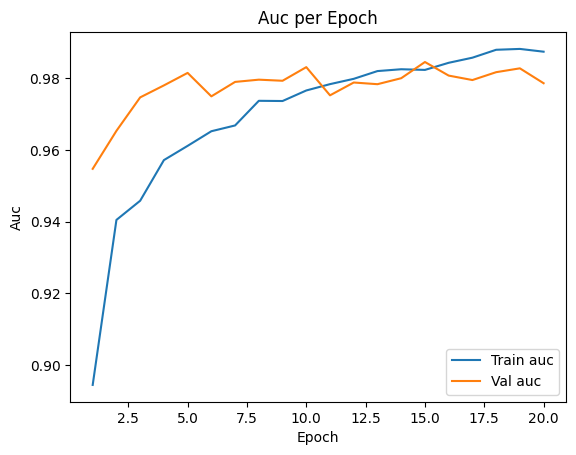

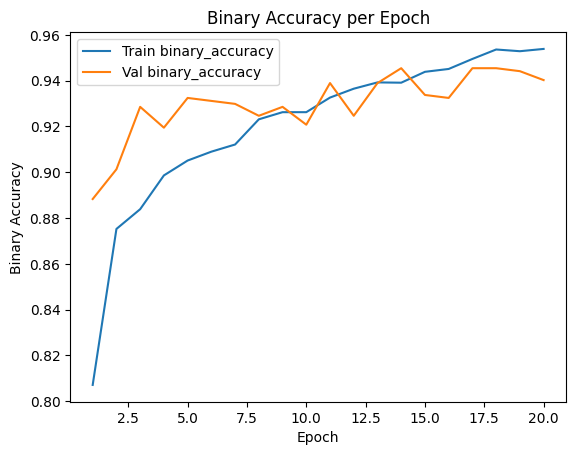

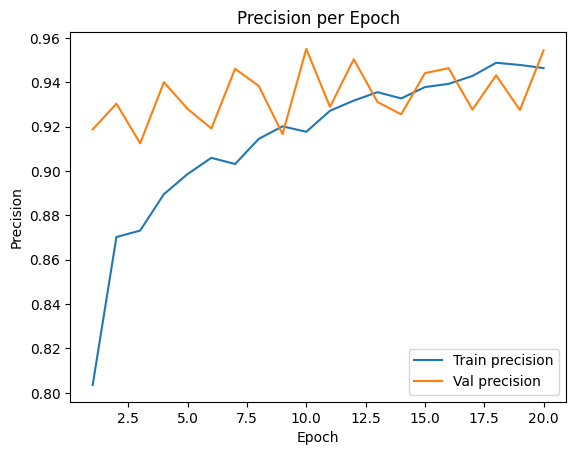

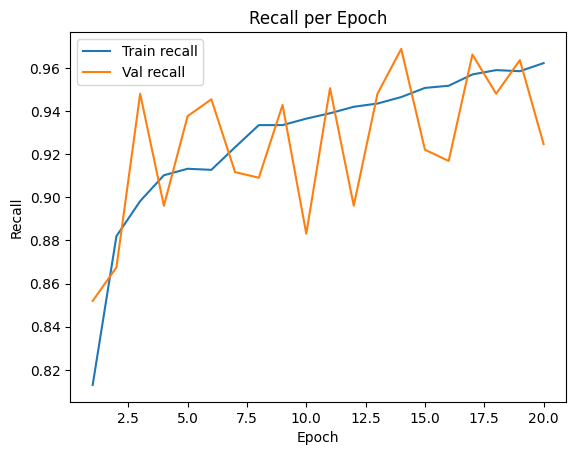

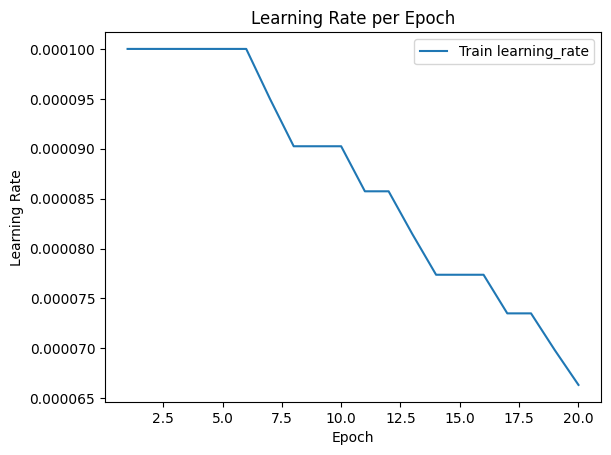

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Metrik eğrilerini çizdiğin kod aynen burada kalsın ---
all_keys = history.history.keys()
train_metrics = [k for k in all_keys if not k.startswith('val_') and k != 'loss']
epochs = range(1, len(history.history[train_metrics[0]]) + 1)

for metric in train_metrics:
    plt.figure()
    plt.plot(epochs, history.history[metric], label=f"Train {metric}")
    val_key = f"val_{metric}"
    if val_key in history.history:
        plt.plot(epochs, history.history[val_key], label=f"Val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} per Epoch")
    plt.legend()
    plt.show()




In [ ]:
model.save('/content/drive/MyDrive/pretrained.h5')
model.load_weights('/content/val-best.h5')
model.evaluate(testGen)

 19/770 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.8942 - binary_accuracy: 0.9307 - loss: 0.1985 - precision: 0.8895 - recall: 0.7898

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.9766 - binary_accuracy: 0.9170 - loss: 0.2835 - precision: 0.9344 - recall: 0.8960


[0.2828037440776825,
 0.9233766198158264,
 0.9792578816413879,
 0.9453551769256592,
 0.8987013101577759]

# Double training data with the other uniqely seeded training generator to prevent overfitting and continue training

In [ ]:
model.load_weights('/content/drive/MyDrive/pretrained.h5')
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9901 - binary_accuracy: 0.9610 - loss: 0.1962 - precision: 0.9564 - recall: 0.9671

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc: 0.9901 - binary_accuracy: 0.9610 - loss: 0.1962 - precision: 0.9564 - recall: 0.9671 - val_auc: 0.9795 - val_binary_accuracy: 0.9481 - val_loss: 0.2456 - val_precision: 0.9302 - val_recall: 0.9688 - learning_rate: 6.3025e-05
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9921 - binary_accuracy: 0.9669 - loss: 0.1794 - precision: 0.9619 - recall: 0.9724

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc: 0.9921 - binary_accuracy: 0.9669 - loss: 0.1795 - precision: 0.9619 - recall: 0.9724 - val_auc: 0.9801 - val_binary_accuracy: 0.9351 - val_loss: 0.2540 - val_precision: 0.9420 - val_recall: 0.9273 - learning_rate: 6.3025e-05
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9924 - binary_accuracy: 0.9678 - loss: 0.1740 - precision: 0.9674 - recall: 0.9688

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc: 0.9924 - binary_accuracy: 0.9678 - loss: 0.1740 - precision: 0.9674 - recall: 0.9688 - val_auc: 0.9777 - val_binary_accuracy: 0.9416 - val_loss: 0.2534 - val_precision: 0.9229 - val_recall: 0.9636 - learning_rate: 5.9874e-05
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.9933 - binary_accuracy: 0.9719 - loss: 0.1614 - precision: 0.9690 - recall: 0.9743

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc: 0.9933 - binary_accuracy: 0.9719 - loss: 0.1614 - precision: 0.9690 - recall: 0.9743 - val_auc: 0.9817 - val_binary_accuracy: 0.9481 - val_loss: 0.2155 - val_precision: 0.9302 - val_recall: 0.9688 - learning_rate: 5.6880e-05
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 334s 167ms/step - auc: 0.9932 - binary_accuracy: 0.9716 - loss: 0.1554 - precision: 0.9684 - recall: 0.9752 - val_auc: 0.9823 - val_binary_accuracy: 0.9442 - val_loss: 0.2291 - val_precision: 0.9362 - val_recall: 0.9532 - learning_rate: 5.6880e-05


With the help of a large deep learning model and advanced preprocessing to prevent overfitting, the benchmrk has improved

In [ ]:
model.save('/content/drive/MyDrive/pretrained2.h5')
model.load_weights('/content/drive/MyDrive/pretrained2.h5')
model.evaluate(testGen)

770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.9756 - binary_accuracy: 0.9455 - loss: 0.2472 - precision: 0.9386 - recall: 0.9599


[0.2508666217327118,
 0.948051929473877,
 0.9770179986953735,
 0.9389312863349915,
 0.9584415555000305]

Found 770 images belonging to 2 classes.
770/770 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc_1: 0.4881 - binary_accuracy: 0.9423 - loss: 0.2613 - precision_1: 0.4197 - recall_1: 0.4692

Test Loss ve Metikler: [0.25339990854263306, 0.9467532634735107, 0.9770854711532593, 0.9479166865348816, 0.9454545378684998]

770/770 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


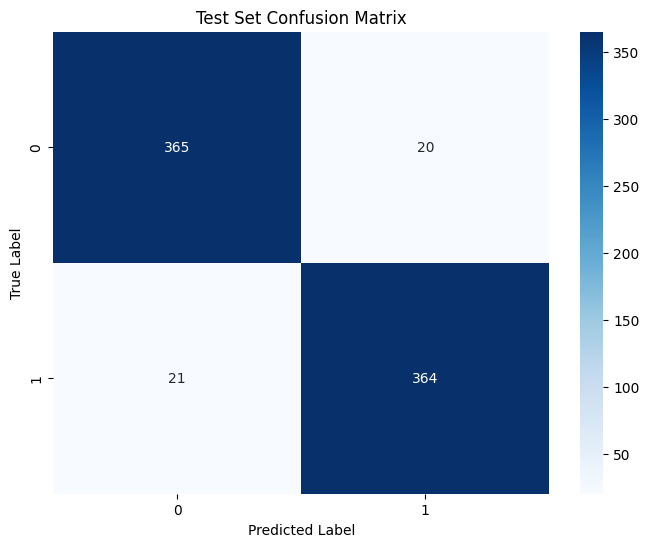

              precision    recall  f1-score   support

           0     0.9456    0.9481    0.9468       385
           1     0.9479    0.9455    0.9467       385

    accuracy                         0.9468       770
   macro avg     0.9468    0.9468    0.9468       770
weighted avg     0.9468    0.9468    0.9468       770



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) Test generator'ü (modelin beklediği boyutta) yeniden oluştur
testDataGen = ImageDataGenerator(preprocessing_function=None)
testGen = testDataGen.flow_from_directory(
    directory=f"{dataPath}/test",
    target_size=(256, 256),    # ⚠️ modelinizin giriş boyutu
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

# 2) Model mimarisini yeniden oluştur ve derle
model = get_model(image_size=256, num_classes=1)
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
)

# 3) Kaydedilmiş ağırlıkları yükle
model.load_weights('/content/drive/MyDrive/pretrained2.h5')

# 4) Değerlendir
eval_results = model.evaluate(testGen, steps=len(testGen), verbose=1)
print(f"\nTest Loss ve Metikler: {eval_results}\n")

# 5) Confusion Matrix hesapla
y_true = testGen.classes
y_prob = model.predict(testGen, steps=len(testGen), verbose=1)
y_pred = (y_prob > 0.5).astype(int).flatten()  # binary için eşik 0.5

cm = confusion_matrix(y_true, y_pred)

# 6) Görselleştir
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Set Confusion Matrix')
plt.show()

# 7) Detaylı sınıflandırma raporu
print(classification_report(y_true, y_pred, digits=4))


# Keras formatına dönüştürme

In [ ]:

# (Önce mimariyi yeniden oluşturup ağırlıkları yüklemeniz gerekebilir:)
from tensorflow.keras.applications.convnext import ConvNeXtTiny
# … buraya get_model fonksiyonunuz gelecek, ya da doğrudan ConvNeXtTiny çağrısı …
model = get_model(image_size=256, num_classes=1)
model.load_weights('/content/drive/MyDrive/pretrained2.h5')

# Ardından native formatta kaydedin
model.save('/content/drive/MyDrive/production_model2.keras')


# Finetuning modelin metrikleri

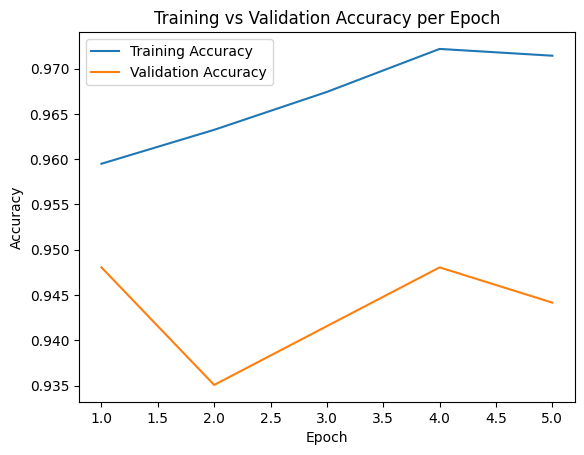

In [ ]:
import matplotlib.pyplot as plt

# history, model.fit(...)'ten dönen History objesi
train_acc = history.history['binary_accuracy']
val_acc   = history.history['val_binary_accuracy']
epochs    = range(1, len(train_acc) + 1)

plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy per Epoch')
plt.legend()
plt.show()

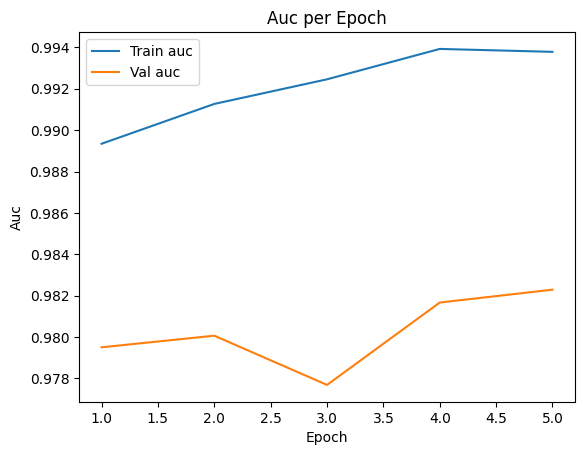

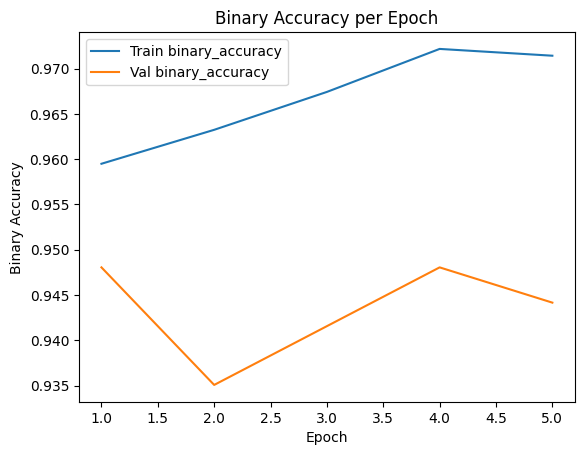

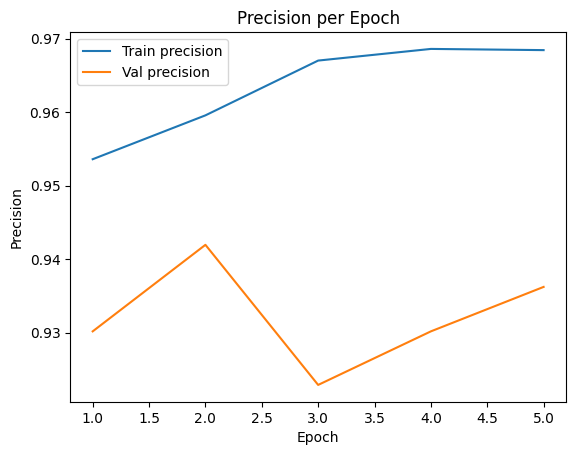

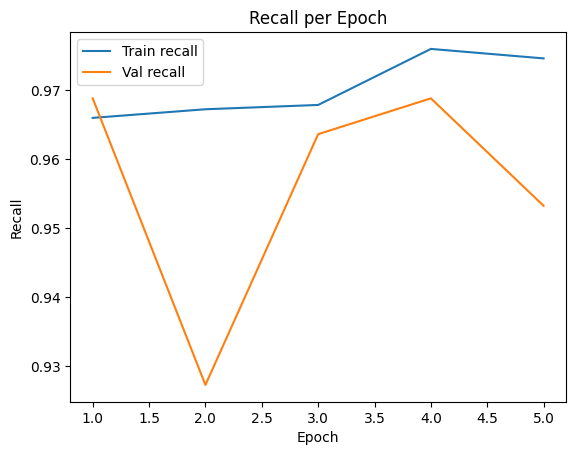

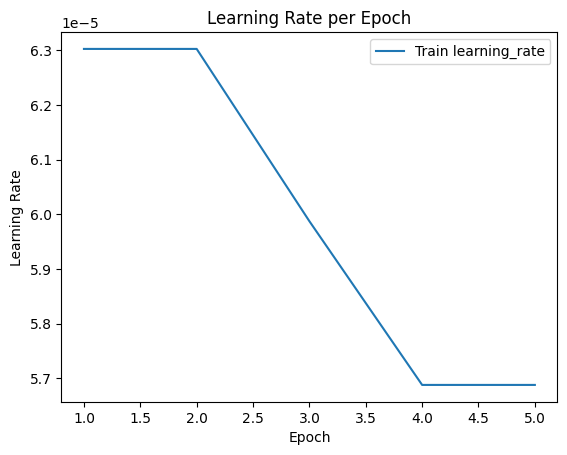

In [ ]:
# 2) Grafikleri çizme
import matplotlib.pyplot as plt

all_keys = history.history.keys()
train_metrics = [k for k in all_keys if not k.startswith('val_') and k != 'loss']
epochs = range(1, len(history.history[train_metrics[0]]) + 1)

for metric in train_metrics:
    plt.figure()
    plt.plot(epochs, history.history[metric], label=f"Train {metric}")
    val_key = f"val_{metric}"
    if val_key in history.history:
        plt.plot(epochs, history.history[val_key], label=f"Val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} per Epoch")
    plt.legend()
    plt.show()

# Test

In [ ]:
# 1) Gerekli kütüphaneler
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt

# 2) Modelinizi yükleyin
# Eğer .h5 formatında kaydettiyseniz:
model = tf.keras.models.load_model('/content/drive/MyDrive/production_model2.keras')
# Eğer sadece weights dosyanız varsa:
# model = get_model(image_size=256, num_classes=1)
# model.load_weights('val-best.h5')

# 3) Kullanıcıdan bir fotoğraf yüklemesini isteyin
uploaded = files.upload()  # bu size bir dosya yükletir
img_path = next(iter(uploaded.keys()))  # yüklenen ilk dosyanın adı

# 4) Fotoğrafı model giriş boyutuna getirip array’e çevirin
target = 256  # modelinizi bu boyutta eğittiyseniz
img = image.load_img(img_path, target_size=(target, target))
x   = image.img_to_array(img)      # shape = (256,256,3)
x   = x.astype('float32')          # eğitimde de float32 kullandınız
x   = np.expand_dims(x, axis=0)    # shape = (1,256,256,3)

# 5) Sınıflandırma (tahmin) ve yüzdelere çevirme
pred = model.predict(x)[0][0]      # binary sigmoid → tek olasılık
p0   = (1 - pred) * 100             # sınıf 0 olasılığı yüzde
p1   = pred       * 100             # sınıf 1 olasılığı yüzde

# 6) Sonucu ekrana basın
print(f"Sınıf 0 (negatif) olasılığı: {p0:.2f}%")
print(f"Sınıf 1 (pozitif) olasılığı: {p1:.2f}%")

# 7) (Opsiyonel) Yüklenen resmi tekrar gösterin
plt.imshow(img)
plt.axis('off')
plt.title(f"Pred: {p1:.1f}% pozitif, {p0:.1f}% negatif")
plt.show()
